Итак, настало время провести свой первый A/B тест.

## Задание
Представьте, что вы работаете аналитиком в очень крупной компании по доставке пиццы над приложением для курьеров (да, обычно в таких компаниях есть приложение для курьеров и отдельно приложение для потребителей).

У вас есть несколько ресторанов в разных частях города и целый штат курьеров. Но есть одна проблема — к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. Это приводит к тому, что в момент пересмены наша доставка очень сильно проседает в эффективности. 

Наши data scientist-ы придумали новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой. 

Вы вместе с командой решили раскатить A/B тест на две равные группы курьеров. Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию и могут ее выбрать. Ваша задача – проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьеров.

## Описание данных
* `order_id - id` заказа
* `delivery_time` - время доставки в минутах
* `district` - район доставки
* `experiment_group` - экспериментальная группа


## Задание 1

Для начала давайте сформулируем гипотезы для проверки. Выберите статистические гипотезы, которые мы сможем проверить в этом эксперименте:

* Нулевая гипотеза (H0): Разница между средним временем доставки в тестовой и контрольной группе есть

* **Альтернативная гипотеза (H1): Разница между средним временем доставки в тестовой и контрольной группе есть**

* Нулевая гипотеза (H0): Изменение алгоритма не влияет на скорость доставки

* Альтернативная гипотеза (H1): Разницы между средним временем доставки в тестовой и контрольной нет

* **Нулевая гипотеза (H0): Разницы между средним временем доставки в тестовой и контрольной группе нет**

* Альтернативная гипотеза (H1): Изменение алгоритма влияет на скорость доставки


# Задание 2
Сопоставьте графики распределения и  экспериментальные группы:

A)
![](https://ucarecdn.com/84dd7581-93ac-4914-81bd-07284b9f62ae/)

Б)
![](https://ucarecdn.com/b08ec5ac-4fe8-43fc-bd3d-3edac1349bd0/)

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy
from scipy import stats

In [3]:
data = pd.read_csv('data2/experiment_lesson_4.csv')
data.head()

order_id  delivery_time  district experiment_group
0      3159           44.0  Purlieus          control
1     10426           51.0  Purlieus          control
2      9155           46.0  Purlieus          control
3     10699           34.0  Purlieus          control
4     10061           43.0  Purlieus          control

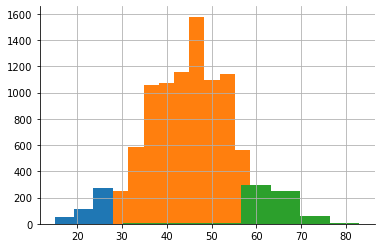

In [33]:
data.query("experiment_group == 'control'").groupby('district').delivery_time.hist()
sns.despine()

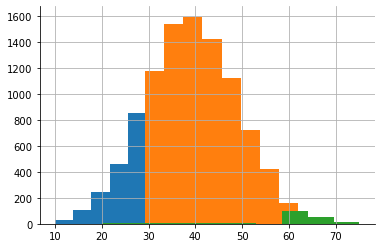

In [34]:
data.query("experiment_group == 'test'").groupby('district').delivery_time.hist()
sns.despine()

б - `тест`

а - `контроль`

# Задание 3
Посчитайте количество наблюдений в тестовой и контрольной группе. На сколько по модулю отличается количество наблюдений в тесте и контроле?

In [38]:
data.query("experiment_group == 'test'").value_counts().sum()

10104

In [39]:
data.query("experiment_group == 'control'").value_counts().sum()

10092

In [40]:
data.query("experiment_group == 'test'").value_counts().sum() - 
data.query("experiment_group == 'control'").value_counts().sum()

12

Ответ: `12`


# Задание 4
Теперь давайте изучим наши распределения. Проверим выполнение условий на нормальность и посчитаем стандартное отклонение в тесте и в контроле.

Обязательно сделайте семплирование перед применением критерия при проверке на нормальность (и для теста, и для контроля), так как на больших выборках вы можете получать неверные результаты: 
```python
experiment[experiment['experiment_group'] == 'test']['delivery_time'].sample(1000, random_state=17)
```
Почему тест может дать здесь неправильный ответ? Загляните в подсказки - в первом пункте мы постарались осветить этот момент подробнее :)

Заполните пропуски ниже:

In [72]:
scipy.stats.shapiro(data[data['experiment_group'] == 'test']['delivery_time'].sample(1000, random_state=17))

ShapiroResult(statistic=0.9975479245185852, pvalue=0.14013493061065674)

In [73]:
scipy.stats.shapiro(data[data['experiment_group'] == 'control']['delivery_time'].sample(1000, random_state=17))

ShapiroResult(statistic=0.9974725842475891, pvalue=0.12411931157112122)

In [70]:
np.round(data.query("experiment_group == 'test'").delivery_time.std(), 2)

9.88

In [71]:
np.round(data.query("experiment_group == 'control'").delivery_time.std(), 2)

9.99

Для того, чтобы проверить нормальность распределения, я использую `SHAPIRO-WILK TEST`. Этот тест показывает, что значения в тестовой группе распределены `НОРМАЛЬНО`. В контрольной группе распределение является `НОРМАЛЬНЫМ`. Стандартное отклонение времени доставки в тесте равно (округлите до сотых) `9.88`. Стандартное отклонение времени доставки в контроле равно (округлите до сотых) `9.99`.


# Задание 5

Пришло время сравнить средние в тесте и контроле. Внимание: здесь уже не нужно пользоваться методом .sample() — он нам нужен был только для теста Шапиро-Уилка, остальные тесты надо проводить на полных данных.

Заполните пропуски ниже:

In [81]:
scipy.stats.ttest_ind(data.query("experiment_group == 'test'").delivery_time, 
                      data.query("experiment_group == 'control'").delivery_time )

Ttest_indResult(statistic=-43.03582663183714, pvalue=0.0)

Для сравнения средних в данных экспериментальных группах я использую `STUDENT'S T-TEST`. Статистика в тесте равна (округлите до целого) `-43`, p-value `<= 0.05`.


# Задание 6

На сколько процентов изменилось среднее время доставки в тестовой группе по сравнению с контрольной (округлите до сотых)? 

Знак изменения необходимо учесть!

In [82]:
data.query("experiment_group == 'test'").delivery_time.mean()

39.04681314330958

In [83]:
data.query("experiment_group == 'control'").delivery_time.mean()

45.065101070154576

In [119]:
np.round(((data.query("experiment_group == 'test'").delivery_time.mean() -
         data.query("experiment_group == 'control'").delivery_time.mean()) / 
         data.query("experiment_group == 'control'").delivery_time.mean()) * 100, 2)

-13.35

Ответ: `-13.35`

# Что в итоге? Катим? 

* Да, раскатываем на всех, новый алгоритм напрямую влияет на скорость доставки.
* Да, раскатываем новый алгоритм на всех, так как среднее время доставки статистически значимо изменилось. Среднее время доставки в тесте больше, чем в контроле.
* **Да, раскатываем новый алгоритм на всех, так как среднее время доставки статистически значимо изменилось. Среднее время доставки в тесте меньше, чем в контроле.**
* Не катим, так как среднее время доставки статистически значимо не изменилось.